## Univariate analysis

### Data

In [1]:
import datetime
import time
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

##### Plotting

In [2]:
plt.figure(figsize = (6, 4))
sns.set_style("whitegrid", {'axes.linewidth': 1.5})
sns.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
# context = talk

#### Bitcoincharts

In [3]:
charts = ['bitbay', 'bitkonan', 'bitstamp', 'hitbtc', 'itbit', 'kraken', 'localbtc', 'rock']
data = {}
labels = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)', 'Weighted Price']

for index, chart in enumerate(charts): 
    exec("with open('data/{}.json') as fi: data[chart] = json.load(fi)".format(chart)) 
    exec("df{} = pd.DataFrame.from_records(data[chart], columns = labels)".format(index))
    exec("df{}['Date'] = pd.to_datetime(df{}['Timestamp'], unit = 's')".format(index, index))
    exec("df{}.set_index('Date', inplace = True)".format(index))
    exec("df{}.drop('Timestamp', 1, inplace = True)".format(index))
    exec("df{} = df{}.replace(1.7e+308, np.nan)".format(index, index))

***

## Models

In [4]:
from sklearn import linear_model, metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
mape  = lambda x, y: np.abs((y - x) / y).mean()*100

### Target: Close variable

#### Preprocessing

In [6]:
df = df2.copy()
df = df[['Close']]
df = df.interpolate(method = 'linear')

df['dayofweek'] = df.index.map(lambda x: x.dayofweek)
df['doy'] = df.index.map(lambda x: x.dayofyear)
df['month'] = df.index.map(lambda x: x.month)
df['woy'] = df.index.map(lambda x: x.weekofyear)
df['qrt'] = df.index.map(lambda x: x.quarter)

df = df.ix['2011-09-13':]

for s in [3, 7, 14, 28]:
    df['Close{}'.format(s)] = df.Close.shift(s)
df = df.bfill()

start = '2016-01-01'
train = df[df.index < start]
val = df[start:]

y_train = train.Close
y_val = val.Close

del train['Close']
del val['Close']

In [7]:
train.head()

,dayofweek,doy,month,woy,qrt,Close3,Close7,Close14,Close28
Date,,,,,,,,,
2011-09-13,1,256,9,37,3,5.97,5.97,5.97,5.97
2011-09-14,2,257,9,37,3,5.97,5.97,5.97,5.97
2011-09-15,3,258,9,37,3,5.97,5.97,5.97,5.97
2011-09-16,4,259,9,37,3,5.97,5.97,5.97,5.97
2011-09-17,5,260,9,37,3,5.53,5.97,5.97,5.97


#### Linear regression

0
 Model MAE: 25.529, RMSE: 42.122, MAPE: 3.607


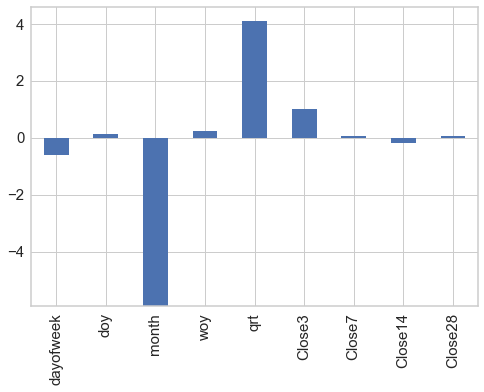

In [8]:
models = [linear_model.LinearRegression()]

results = pd.DataFrame()
for index, model in enumerate(models):
    model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n Model MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred),np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    pd.Series(model.coef_, index = train.columns).plot(kind = 'bar')
        
results = pd.concat((results, y_val), axis = 1)
results.columns = ['lr', 'true']

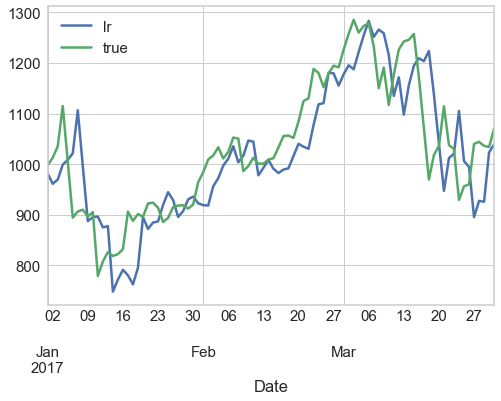

In [9]:
results.ix['2017-01-01':].plot()

In [10]:
results.ix['2017-01-01':].head()

,lr,true
Date,,
2017-01-01,981.131179,997.75
2017-01-02,961.077839,1012.54
2017-01-03,969.274477,1035.24
2017-01-04,998.790467,1114.92
2017-01-05,1008.382358,1004.74


#### Other models

In [11]:
models = [DecisionTreeRegressor(max_depth = 10, random_state = 16),\
          KNeighborsRegressor(n_neighbors = 5),\
          RandomForestRegressor(n_estimators = 5, random_state = 16),\
          GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.025, max_depth = 10,\
                                    subsample = 0.75, random_state = 16)]

results = pd.DataFrame()
for index, model in enumerate(models):
    model = model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred), np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    
results = pd.concat((results, y_val), axis=1)
results.columns = ['dt', 'knn', 'rf', 'gbr', 'true']
# results['ens_mean'] = results[['knn', 'dt', 'lr', 'gbr', 'rf']].mean(axis=1)

0
 MAE: 104.250, RMSE: 168.785, MAPE: 16.054
1
 MAE: 90.907, RMSE: 142.291, MAPE: 14.041
2
 MAE: 88.790, RMSE: 152.636, MAPE: 13.444
3
 MAE: 112.987, RMSE: 187.871, MAPE: 18.721


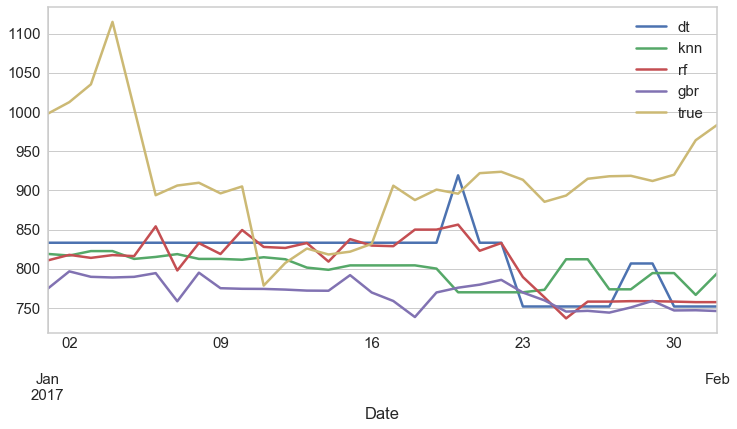

In [12]:
results.ix['2017-01-01':'2017-02-01'].plot(figsize = (12, 6))

### Target: Volume (BTC) variable

#### Preprocessing

In [13]:
df = df5.copy()
df = df[['Volume (BTC)']]
df.columns = ['vol_btc']
df = df.interpolate(method = 'linear')

df['dayofweek'] = df.index.map(lambda x: x.dayofweek)
df['doy'] = df.index.map(lambda x: x.dayofyear)
df['month'] = df.index.map(lambda x: x.month)
df['woy'] = df.index.map(lambda x: x.weekofyear)
df['qrt'] = df.index.map(lambda x: x.quarter)

df = df.ix['2014-01-07':]

for s in [3, 7, 14]:
    df['vol_btc{}'.format(s)] = df.vol_btc.shift(s)
df = df.bfill()

start = '2016-06-01'
train = df[df.index < start]
val = df[start:]

y_train = train.vol_btc
y_val = val.vol_btc

del train['vol_btc']
del val['vol_btc']

#### Linear regression

0
 Model MAE: 922.614, RMSE: 1461.136, MAPE: 54.481
1
 Model MAE: 922.614, RMSE: 1461.136, MAPE: 54.481
2
 Model MAE: 2353.891, RMSE: 3014.363, MAPE: 108.542


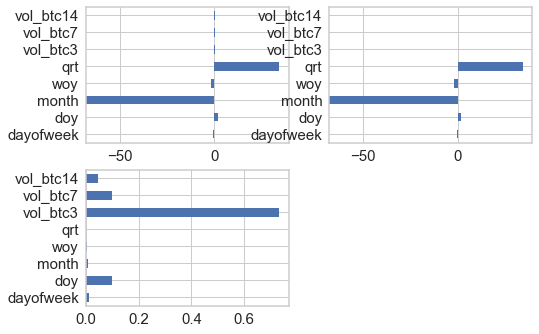

In [14]:
models = [linear_model.LinearRegression(),\
          linear_model.LinearRegression(normalize = True),\
          DecisionTreeRegressor(max_depth = 10, random_state = 16)]

fig = plt.figure()
results = pd.DataFrame()
for index, model in enumerate(models):
    model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n Model MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred),np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis = 1)
    if (index == 0 or index == 1):
        fig.add_subplot(221 + index)
        pd.Series(model.coef_, index = train.columns).plot(kind = 'barh')
    elif (index == 2):
        fig.add_subplot(221 + index)
        pd.Series(model.feature_importances_, index = train.columns).plot(kind = 'barh')
        
results = pd.concat((results, y_val), axis = 1)
results.columns = ['lr', 'lr-norm', 'dt', 'true']

#### Other models

In [15]:
models = [linear_model.Ridge(),\
          DecisionTreeRegressor(max_depth = 35, random_state = 16),\
          KNeighborsRegressor(n_neighbors = 30),\
          RandomForestRegressor(n_estimators = 40, random_state = 16),\
          GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.025, max_depth = 10,\
                                    subsample = 0.5, random_state = 16)]

results = pd.DataFrame()
for index, model in enumerate(models):
    model = model.fit(train, y_train)
    pred = pd.Series(model.predict(val).ravel(), index = val.index)
    print('%s\n MAE: %.3f, RMSE: %.3f, MAPE: %.3f' %\
      (index, metrics.mean_absolute_error(y_val, pred), np.sqrt(metrics.mean_squared_error(y_val, pred)), mape(y_val, pred)))
    results = pd.concat((results, pred), axis=1)
    
results = pd.concat((results, y_val), axis=1)
results.columns = ['lr', 'dt', 'knn', 'rf', 'gbr', 'true']
# results['ens_mean'] = results[['knn', 'dt', 'lr', 'gbr', 'rf']].mean(axis=1)

0
 MAE: 922.551, RMSE: 1461.071, MAPE: 54.480
1
 MAE: 2355.386, RMSE: 3007.699, MAPE: 108.942
2
 MAE: 928.255, RMSE: 1523.490, MAPE: 60.438
3
 MAE: 1058.334, RMSE: 1618.182, MAPE: 65.342
4
 MAE: 1033.204, RMSE: 1589.240, MAPE: 63.187


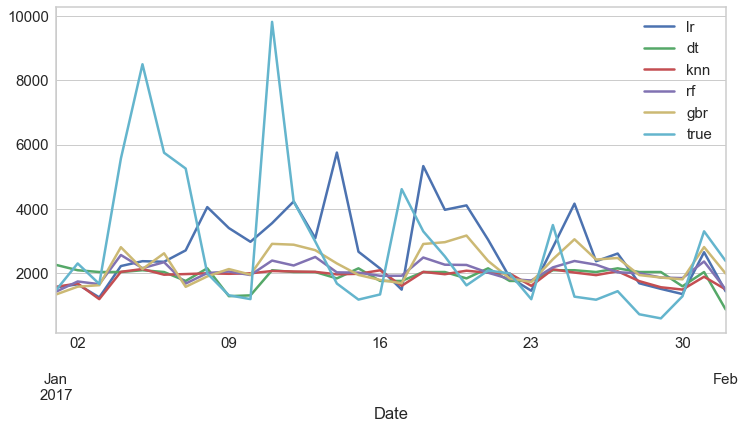

In [16]:
results.ix['2017-01-01':'2017-02-01'].plot(figsize = (12, 6))